# RatS Day2NSD recording info
- No timestamps were deleted after concatenating .dat files from various folders of open-ephys

In [6]:
import numpy as np
import subjects

sess = subjects.nsd.ratSday2[0]
print(sess.recinfo)

filename: /data/Clustering/sessions/RatS/Day2NSD/RatS-Day2NSD-2020-11-27_10-22-29.xml 
# channels: 195
sampling rate: 30000
lfp Srate (downsampled): 1250



# Set probe configuration
- RatS_Day2NSD has two probes: 64chan-6shanks cambridge neurotech and 128chan-8shanks diagnostic biochips.
- Channel 51 on 64chan probe is skull eeg channel located above prefrontal cortex. This channel was a little buggy, the signal quality kept varying.
- The cambridge neurotech probe also has accelerometer data in channels: 192, 193, 194

In [ ]:
%matplotlib widget
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe

shanks = []
channel_groups = sess.recinfo.channel_groups
badchans = sess.recinfo.skipped_channels

#--- cambridge probe -----------
for i in range(6):
    chans = channel_groups[i]

    if len(chans)==10:
        n_cont = 5
        y_shift = [0,7.5]
    if len(chans)==11:
        n_cont = [6,5]
        y_shift = [0,7.5]
    if len(chans)==9:
        n_cont = [5,4]
        y_shift = [0,7,5]

    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=n_cont,
        xpitch=16.5,
        ypitch=15,
        y_shift_per_column=y_shift,
        channel_id=np.append(
            channel_groups[i][1::2][::-1], channel_groups[i][::2][::-1]
        ),
    )
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)
    shanks.append(shank)

probe1 = Probe(shanks)

shanks = []
for i in range(6,14):

    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=15,
        y_shift_per_column=[0, -7.5],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)
    shanks.append(shank)


probe2 = Probe(shanks)
probe2.move((probe1.x_max+500,0))

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)
prbgrp.add_probe(probe2)

prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
# prbgrp.save()
plot_probe(prbgrp,channel_id=False)

## Create epochs for your experimental paradigm
- RatS_Day2NSD had digitized noise in first ~2 hours of pre sleep. I somehow didn't notice that while recording, so the pre sleep is a lot shorter comapred to other animals.

In [2]:
sess.paradigm.to_dataframe()

,start,stop,label,duration
0,0,2358,pre,2358
1,2360,6031,maze,3671
2,6033,36899,post,30866
3,36902,40233,re-maze,3331


In [ ]:
import pandas as pd
from neuropy.core import Epoch

epochs = pd.DataFrame(
    {
        "start": [0, 2360,6033,36902],
        "stop": [2358, 6031, 36899, 40233],
        "label": ["pre", "maze", "post",'re-maze'],
    }
)

paradigm = Epoch(epochs=epochs)
paradigm.filename = sess.filePrefix.with_suffix(".paradigm.npy")
# paradigm.save()


# Detect epochs
Here we will various types of epochs which typical for hippocampal recordings.

## Artifacts epochs
A typical session will have some artifacts that may negatively influence many analyses. Using a simple zscore measure, we can identify epochs where signal is above some threshold.

In [ ]:
signal = sess.eegfile.get_signal([1])
artifact_epochs = analyses.detect_artifact_epochs(signal, thresh=7)
artifact_epochs.filename = sess.filePrefix.with_suffix(".artifact.npy")
artifact_epochs.save()
plotting.plot_artifact_epochs(artifact_epochs, signal)


## Ripple epochs
To detect ripples one also needs probegroup.

In [ ]:
from neuropy.analyses import oscillations
signal = sess.eegfile.get_signal()
ripple_epochs =oscillations.detect_ripple_epochs(signal, sess.probegroup)
ripple_epochs.filename = sess.filePrefix.with_suffix('.ripple.npy')
ripple_epochs.save()

In [ ]:
signal = sess.eegfile.get_signal(channel_id=[1, 2, 3, 4], t_start=1, t_stop=1.2)
plotting.plot_signal_traces(signal)

# Importing spiketrains from Phy

In [4]:
from neuropy.io import PhyIO
from neuropy.core import Neurons
from pathlib import Path
import numpy as np

cluster_path = Path(
    "/data/Clustering/sessions/RatS/Day2NSD/spykcirc/RatS-Day2NSD-2020-11-27_10-22-29-1.GUI"
)
chan_grps = sess.recinfo.channel_groups
phy_data = PhyIO(cluster_path)
spiketrains =phy_data.spiketrains
peak_chans = phy_data.peak_channels
waveforms = phy_data.waveforms
shank_id = sess.probegroup.get_shank_id_for_channels(peak_chans)

# neuron_type_id = phy_data.cluster_info.q.values
# neuron_type = np.ones(len(neuron_type_id), dtype="U5")
# neuron_type[neuron_type_id<4] = 'pyr'
# neuron_type[neuron_type_id==6] = 'mua'
# neuron_type[neuron_type_id==8] = 'inter'

neurons = Neurons(
    np.array(spiketrains, dtype=object),
    t_stop=sess.eegfile.duration,
    sampling_rate=phy_data.sampling_rate,
    peak_channels=peak_chans,
    waveforms=np.array(waveforms,dtype='object'),
    shank_ids=np.array(shank_id).astype(int),
    neuron_type=sess.neurons.neuron_type,
)

neurons.filename = sess.filePrefix.with_suffix('.neurons')
neurons.save()


RatS-Day2NSD-2020-11-27_10-22-29.neurons saved


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from neuropy.plotting import plot_raster


plt.plot(phy_data.peak_waveforms[0])
plot_raster(neurons,color='jet',add_vert_jitter=True)

# BinnedSpiketrain and Mua objects using Neurons

In [ ]:
mua =sess.neurons.get_mua()
mua.filename = sess.filePrefix.with_suffix(".mua.npy")
mua.save()   


In [ ]:
%matplotlib widget
from neuropy import plotting
smth_mua = sess.mua.get_smoothed(sigma=0.02)
plotting.plot_mua(smth_mua)

In [ ]:
from neuropy.analyses import detect_pbe_epochs

pbe = detect_pbe_epochs(smth_mua)
pbe.filename = sess.filePrefix.with_suffix('.pbe')
pbe.save()


# Assign position data
- concatenated .dat file did not have any deleted timepoints

In [2]:
from neuropy.io import OptitrackIO
from neuropy.core import Position
from pathlib import Path

opti_folder = sess.filePrefix.parent / 'position'
opti_data = OptitrackIO(dirname=opti_folder)

/data/Clustering/sessions/RatS/Day2NSD/position/Take 2020-11-27 11.07.50 AM.csv


In [4]:
opti_data.datetime_starts

[datetime.datetime(2020, 11, 27, 11, 7, 50, 765000)]

In [5]:
import pandas as pd
from datetime import datetime

# ------- maze align corection ---------
# Error estimated using TTL manually, spot-on with theta delta, This session does not have remaze position file
t_error = [0, 0.1916, 0, 0, 0, 0]

# ---- startimes of concatenated .dat files
tracking_sRate = opti_data.sampling_rate
rec_datetime = pd.read_csv(sess.filePrefix.with_suffix(".datetime.csv"))
data_time = []
for i, file_time in enumerate(rec_datetime["StartTime"]):
    sync_time = rec_datetime["sync_nframes"][i] / rec_datetime["sync_rate"][i]
    tbegin = datetime.strptime(file_time, "%Y-%m-%d_%H-%M-%S") + pd.Timedelta(
        t_error[i], unit="sec"
    )
    nframes = rec_datetime["nFrames"][i]
    duration = pd.Timedelta(nframes / sess.recinfo.dat_sampling_rate, unit="sec")
    tend = tbegin + duration
    trange = pd.date_range(
        start=tbegin,
        end=tend,
        periods=int(duration.total_seconds() * tracking_sRate),
    )
    data_time.extend(trange)
data_time = pd.to_datetime(data_time)

# # ------- deleting intervals that were deleted from .dat file after concatenating
# ndeletedintervals = rec_datetime.count()["deletedStart (minutes)"]
# for i in range(ndeletedintervals):
#     tnoisy_begin = data_time[0] + pd.Timedelta(
#         rec_datetime["deletedStart (minutes)"][i], unit="m"
#     )
#     tnoisy_end = data_time[0] + pd.Timedelta(
#         rec_datetime["deletedEnd (minutes)"][i], unit="m"
#     )

#     del_index = np.where((data_time > tnoisy_begin) & (data_time < tnoisy_end))[
#         0
#     ]

#     data_time = np.delete(data_time, del_index)

x, y, z = opti_data.get_position_at_datetimes(data_time)
traces = np.vstack((z, x, y))

position = Position(traces=traces, t_start=0, sampling_rate=opti_data.sampling_rate)
position.save(sess.filePrefix.with_suffix('.position'))

/data/Clustering/sessions/RatS/Day2NSD/RatS-Day2NSD-2020-11-27_10-22-29.position saved


In [ ]:
import matplotlib.pyplot as plt

# plt.plot(opti_data.datetime_array,opti_data.z)
plt.plot(sess.position.time,sess.position.x)

# Linearize position

/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:328: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/bapung/miniconda3/envs/data_analysis/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_mat

/data/Clustering/sessions/RatS/Day2NSD/RatS-Day2NSD-2020-11-27_10-22-29.maze.linear saved


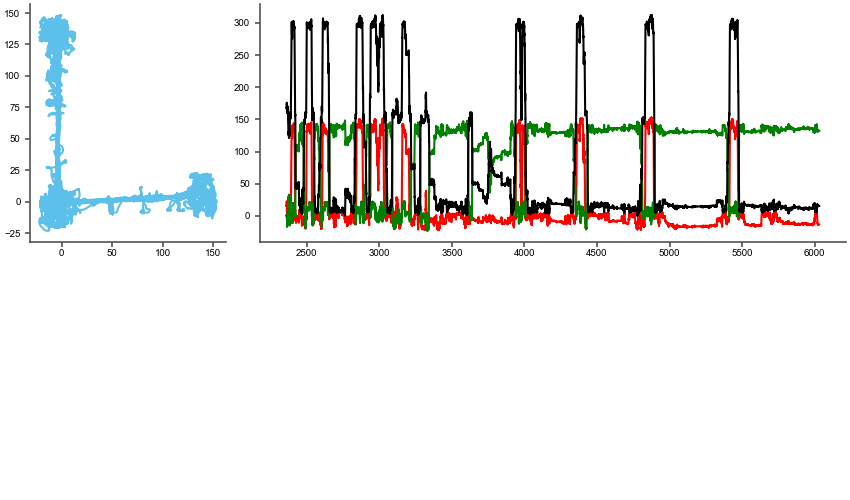

In [7]:
from neuropy.utils import position_util
from neuropy import plotting

maze = sess.paradigm['maze'].flatten()
maze_pos = sess.position.time_slice(maze[0],maze[1])
linear_pos = position_util.linearize_position(maze_pos)
linear_pos.save(sess.filePrefix.with_suffix('.maze.linear'))


fig = plotting.Fig(grid=(2,4),size=(8.5,5))

ax = fig.subplot(fig.gs[0])
ax.plot(maze_pos.x,maze_pos.y)

ax = fig.subplot(fig.gs[0,1:])
ax.plot(maze_pos.time,maze_pos.x,'r')
ax.plot(maze_pos.time,maze_pos.y,'g')
ax.plot(linear_pos.time,linear_pos.x,'k')

# Checking position alignment with .dat file
- Comparing theta power, speed and position to check if high theta periods are correlated with the speed of the animal

In [ ]:
%matplotlib widget
from neuropy.utils import signal_process

signal = sess.eegfile.get_signal([158])
spec = signal_process.SpectrogramBands(signal)

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt

plt.plot(spec.time,spec.theta*1000)
plt.plot(sess.position.time,sess.position.x)
plt.plot(sess.position.time[1:],np.diff(sess.position.x)*100)
# plt.xlim([1500,1600])
plt.ylim([-400,400])

In [ ]:
import numpy as np

maze = sess.paradigm['maze1']

pos_maze = sess.position.time_slice(maze[0],maze[1])
t_spec = spec.time
theta = spec.theta

indices = (t_spec>maze[0]) & (t_spec<maze[1])
t_spec_maze = t_spec[indices]
theta_maze = theta[indices]
theta_upsampled = np.interp(pos_maze.time[1:],t_spec_maze,theta_maze)

xcorr = np.correlate(np.diff(pos_maze.x),theta_maze,mode='same')


In [ ]:
%matplotlib widget
xcorr_span = int(len(xcorr)/2)
bins = np.linspace(-xcorr_span,xcorr_span,len(xcorr))
plt.plot(theta_upsampled*50)
plt.plot(np.diff(pos_maze.y))